# Úkol č. 3 - Segmentace zákazníků e-shopu (do 7. ledna)

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka)
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
pd.set_option('display.max_rows', 1000)
#np.set_printoptions(precision=5, suppress=True)
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [2]:
df = pd.read_csv("eshop.csv")

In [3]:
df.head()

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni


In [4]:
# zde vytvarim RFM dataFrame a uschovavam si zvlast Column 'Customer ID' do Customer

df = df.drop(['Country'],axis=1)
df['Date'] = (pd.to_datetime(dt.date.today()) - pd.to_datetime(df['Date'])).dt.days
df = df.rename(columns={'Date': 'Recency'})

Frequency = df.groupby('Customer ID').size().rename('Frequency').reset_index()
Monetary = df.groupby('Customer ID')['Subtotal'].sum().rename('Monetary').reset_index()

df = df.merge(Monetary)
df = df.merge(Frequency)
df = df.sort_values('Recency').groupby('Customer ID', as_index=False).first()
Customer = df['Customer ID']
df = df.drop(['Subtotal','Customer ID'],axis=1)
df = df[['Recency', 'Monetary', 'Frequency']].apply(lambda x: x.astype('float64'))

In [5]:
def normalizace_dat(data):
    return (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))


In [6]:
def standardizace_dat(data):
    scaler = preprocessing.StandardScaler()
    names = data.columns
    data = scaler.fit_transform(data)
    data = pd.DataFrame(data, columns=names)
    return data

In [7]:
#zobrazeni dat v 3D
def Graf3D(data):
    data = data.sample(n=500)
    scatter = dict(
        mode = "markers",
        name = "Cluster",
        type = "scatter3d",    
        x = data.as_matrix()[:,0], y = data.as_matrix()[:,1], z = data.as_matrix()[:,2],
            marker = dict( size = 2, color = 'green')
    )
    cluster = dict(
        alphahull = 5,
        name = "Cluster",
        opacity = .1,
        type = "mesh3d",    
        x = data.as_matrix()[:,0], y = data.as_matrix()[:,1], z = data.as_matrix()[:,2],
            color = 'green', showscale = True
    )
    layout = dict(
        title = 'Sample(500) of my data in 3D',
        scene = dict(
            xaxis = dict( zeroline = True ),
            yaxis = dict( zeroline = True ),
            zaxis = dict( zeroline = True ),
        )
    )
    fig = dict( data = [scatter, cluster], layout = layout )
    plotly.offline.iplot(fig, filename='mesh3d_sample')

In [8]:
# v dalsich bodech zadani budu vyuzivat tyto data (standardizovane)
# Data by se asi mely nejakym zpusobem preskalovat. Minimalne kvuli priznaku 'Recency', ktery je radove vetsi nez zbyle dva aniz by tam byl nejaky duvod pro takovy rozdil.
# Avsak napriklad 'Monetary' by nejspise melo mit vetsi vahu nez 'Frequency' coz by normalizace trochu vyrusila, proto jsem zvolil standardizaci

df_s = standardizace_dat(df)
Graf3D(df_s)

In [9]:
df_n = normalizace_dat(df)
Graf3D(df_n)

In [10]:
Graf3D(df)

In [11]:
# grafy pomocne na odhadnuti nejlepsiho poctu shluku
def GrafyNaTipShluku(data):
    Z = linkage(data)
    plt.figure(figsize=(15, 7))
    plt.title('Dendrogram hierarchického shlukování')
    plt.xlabel('index bodu nebo (velikost shluku)')
    plt.ylabel('vzdálenost')
    dendrogram(
        Z,
        truncate_mode='lastp',
        p=10, 
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,  
    )
    plt.show()

    ix = np.zeros(7)
    iy = np.zeros(7)
    for k in range(ix.shape[0]):
        kmeans = KMeans(n_clusters=k+1, random_state = 1)
        kmeans.fit(data)
        iy[k] = kmeans.inertia_
        ix[k] = k+1

    plt.xlabel('$k$')
    plt.ylabel('Účelová funkce')
    plt.plot(ix, iy, 'o-')
    plt.show()

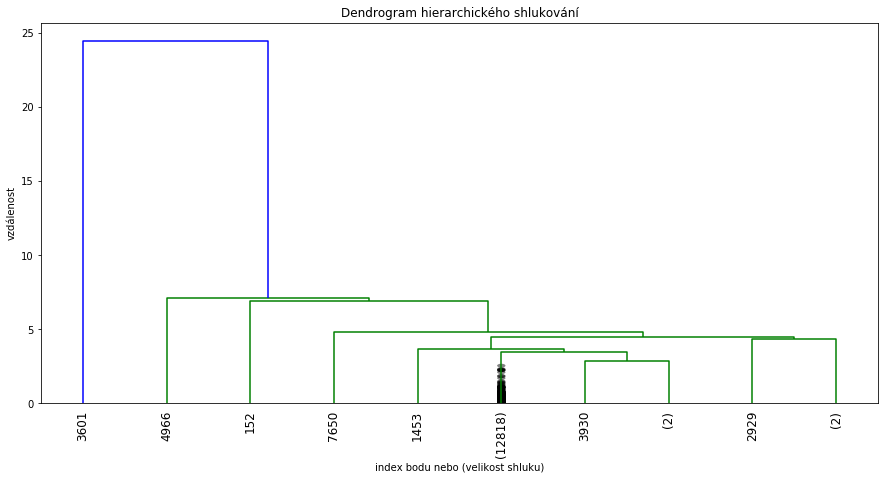

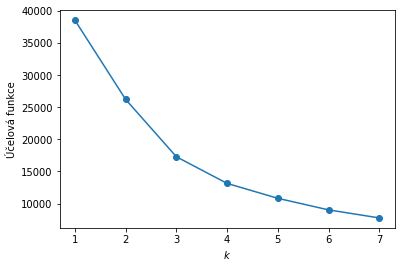

In [12]:
GrafyNaTipShluku(df_s)

In [13]:
# Zvolil jsme pocet shluku na 4.
# na druhem grafu hledame zlom, neboli bod od ktere chvile graf jiz neni tolik klesajici
# na prvnim grafu je asi lehci vybrat prave 4, protoze po ctvrtem shluku jsou jiz mezi dalsimi rozdelenimi male vzdalenosti
k = 4
kmeans = KMeans(n_clusters = k, random_state = 1).fit(df_s)
cluster = pd.DataFrame(kmeans.labels_)
df_clusters = pd.concat([df_s, cluster], axis=1)
df_clusters = df_clusters.rename(columns={0: 'Cluster'})
df_clusters = pd.concat([df_clusters, Customer], axis=1)

In [14]:
# zobrazeni 3D grafu, ktery obsahuje az 6 shluku
def Clusters3D(data,samples):
    
    # protoze dat ve shluku 2 je malo tak je pridavam do nahodneho vyberu vsechny
    data1 = data.sample(n = samples)    
    data1 = data1[data1['Cluster'] != 2]
    data1 = data1.append(data[data['Cluster'] == 2])    
    
    cluster1 = data1[data1['Cluster'] == 0]
    cluster2 = data1[data1['Cluster'] == 1]
    cluster3 = data1[data1['Cluster'] == 2]
    cluster4 = data1[data1['Cluster'] == 3]
    cluster5 = data1[data1['Cluster'] == 4]
    cluster6 = data1[data1['Cluster'] == 5]

    scatter1 = dict(
        mode = "markers",
        name = "Cluster 1",
        type = "scatter3d",    
        x = cluster1.as_matrix()[:,0], y = cluster1.as_matrix()[:,1], z = cluster1.as_matrix()[:,2],
            marker = dict( size=2, color='green')
    )
    scatter2 = dict(
        mode = "markers",
        name = "Cluster 2",
        type = "scatter3d",    
        x = cluster2.as_matrix()[:,0], y = cluster2.as_matrix()[:,1], z = cluster2.as_matrix()[:,2],
            marker = dict( size=2, color='blue')
    )
    scatter3 = dict(
        mode = "markers",
        name = "Cluster 3",
        type = "scatter3d",    
        x = cluster3.as_matrix()[:,0], y = cluster3.as_matrix()[:,1], z = cluster3.as_matrix()[:,2],
            marker = dict( size=2, color='red')
    )
    scatter4 = dict(
        mode = "markers",
        name = "Cluster 4",
        type = "scatter3d",    
        x = cluster4.as_matrix()[:,0], y = cluster4.as_matrix()[:,1], z = cluster4.as_matrix()[:,2],
            marker = dict( size=2, color='yellow')
    )
    scatter5 = dict(
        mode = "markers",
        name = "Cluster 5",
        type = "scatter3d",    
        x = cluster5.as_matrix()[:,0], y = cluster5.as_matrix()[:,1], z = cluster5.as_matrix()[:,2],
            marker = dict( size=2, color='brown')
    )
    scatter6 = dict(
        mode = "markers",
        name = "Cluster 6",
        type = "scatter3d",    
        x = cluster6.as_matrix()[:,0], y = cluster6.as_matrix()[:,1], z = cluster6.as_matrix()[:,2],
            marker = dict( size=2, color='purple')
    )
    cluster1 = dict(
        alphahull = 5,
        name = "Cluster 1",
        opacity = .1,
        type = "mesh3d",    
        x = cluster1.as_matrix()[:,0], y = cluster1.as_matrix()[:,1], z = cluster1.as_matrix()[:,2],
            color='green', showscale = True
    )
    cluster2 = dict(
        alphahull = 5,
        name = "Cluster 2",
        opacity = .1,
        type = "mesh3d",    
        x = cluster2.as_matrix()[:,0], y = cluster2.as_matrix()[:,1], z = cluster2.as_matrix()[:,2],
            color='blue', showscale = True
    )
    cluster3 = dict(
        alphahull = 5,
        name = "Cluster 3",
        opacity = .1,
        type = "mesh3d",    
        x = cluster3.as_matrix()[:,0], y = cluster3.as_matrix()[:,1], z = cluster3.as_matrix()[:,2],
        color='red', showscale = True
    )
    cluster4 = dict(
        alphahull = 5,
        name = "Cluster 4",
        opacity = .1,
        type = "mesh3d",    
        x = cluster4.as_matrix()[:,0], y = cluster4.as_matrix()[:,1], z = cluster4.as_matrix()[:,2],
            color='yellow', showscale = True
    )
    cluster5 = dict(
        alphahull = 5,
        name = "Cluster 5",
        opacity = .1,
        type = "mesh3d",    
        x = cluster5.as_matrix()[:,0], y = cluster5.as_matrix()[:,1], z = cluster5.as_matrix()[:,2],
            color='brown', showscale = True
    )
    cluster6 = dict(
        alphahull = 5,
        name = "Cluster 6",
        opacity = .1,
        type = "mesh3d",    
        x = cluster6.as_matrix()[:,0], y = cluster6.as_matrix()[:,1], z = cluster6.as_matrix()[:,2],
            color='purple', showscale = True
    )
    layout = dict(
        title = 'My cluster data(sample) in 3D',
        scene = dict(
            xaxis = dict(title='Recency', zeroline=True ),
            yaxis = dict(title='Monetary', zeroline=True ),
            zaxis = dict(title='Frequency', zeroline=True ),
        )
    )
    fig = dict( data=[scatter1,scatter2,scatter3,scatter4,scatter5,scatter6,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6], layout=layout )
    plotly.offline.iplot(fig, filename='mesh3d_sample')

In [15]:
Clusters3D(df_clusters,1000)
# Z grafu je videt,ze cerveny shluku (['Cluster']==2) obsahuje ty 'zajimave' zakazniky
# a 'nezajimavy' zakaznici jsou v modrem shluku (['Cluster']==1)

In [16]:
SuperStar = df_clusters[df_clusters['Cluster'] == 2]
Nezajimave = df_clusters[df_clusters['Cluster'] == 1]